In [1]:
from os import chdir
chdir('..')

In [9]:
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
import pandas as pd
import time
import numpy as np
from polylidar import extractPlanesAndPolygons, extractPolygonsAndTimings
from shapely.geometry import LineString, Polygon, asPolygon
from shapely.ops import cascaded_union, unary_union
from shapely.affinity import scale
from scipy.spatial import Delaunay

from concave_evaluation.helpers import fake_building, plot_line, BLUE, GRAY, plot_arrow, scale_axes
%matplotlib notebook
sns.set()
sns.set_style("whitegrid")

In [3]:

# def gen_points(xmin=0, xmax=10, xstep=1, ymin=0, ymax=10, ystep=1):
#     X, Y = np.mgrid[xmin:xmax:xstep, ymin:ymax:ystep]
#     positions = np.vstack([X.ravel(), Y.ravel()])
#     positions = positions.transpose().copy()
#     return positions


# n_val_bad=[25_000, 50_000, 100_000, 200_000, 400_000, 500_000, 650_000, 800_000, 1_000_000, 1_200_000, 1_600_000, 2_000_000, 2_500_000, 3_200_000, 6_400_000]
# n_val_good=[25_000, 50_000, 100_000, 200_000, 400_000, 800_000, 1_600_000, 3_200_000, 6_400_000, 12_800_000, 25_600_000]
# def polylidar_timings(reps=3, n_val=n_val_good):
#     records = []
#     polylidar_kwargs = dict(xyThresh=0.0, alpha=2.0)
#     for j in range(reps):
#         for n in n_val:
#             valmax = int(math.sqrt(n))
#             points = gen_points(xmax=valmax, ymax=valmax)
#             true_n = points.shape[0]
#             polygons, times = extractPolygonsAndTimings(points, **polylidar_kwargs)
#             records.append(dict(delaunay=times[0], region=times[1], polygon=times[2], n=true_n))
#     return records



# # records = union_timings()
# records = polylidar_timings()
df = pd.read_csv('./analysis/polylidar_complexity.csv')
df

,n,delaunay,region,polygon
0,24964,15.469000,16.716999,10.348000
1,24964,13.064000,14.494000,8.870000
2,24964,12.200000,14.016000,8.900000
3,49729,25.809999,29.132000,18.895000
4,49729,25.545000,28.871000,19.347000
5,49729,25.198999,29.004000,19.525000
6,99856,55.578999,64.088997,41.438999
7,99856,57.796001,63.779999,43.317001
8,99856,57.980000,64.579002,43.886002
9,199809,132.335007,148.268997,100.033997


In [4]:
# points = gen_points(xmax=500, ymax=500)
# polygons, times = extractPolygonsAndTimings(points, alpha=2.0, xyThresh=0.0)

In [5]:
# len(polygons[0].holes)
# points.shape
# # times

<IPython.core.display.Javascript object>


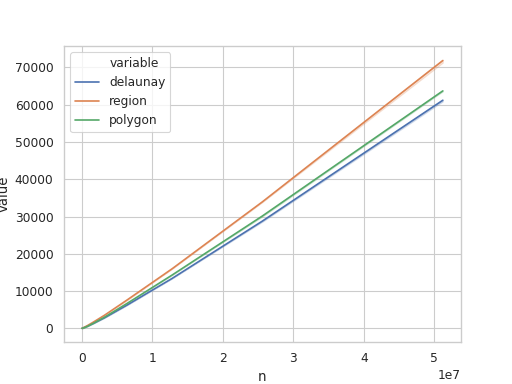

In [12]:
# df = pd.DataFrame.from_records(records)
df_m = pd.melt(df, id_vars =['n'], value_vars =['delaunay', 'region', 'polygon']) 
sns.lineplot(x='n', y='value', hue='variable', data=df_m)


<IPython.core.display.Javascript object>


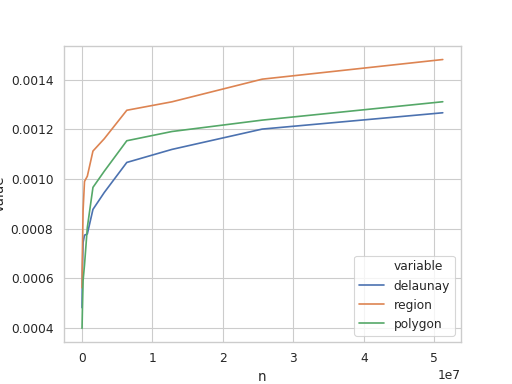

In [11]:
df_means = df.groupby(['n']).mean()
df_means['ns'] = df_means.index
df_diff = df_means.diff()
df_diff['polygon']  / df_diff['ns']
numerator = df_diff[['delaunay', 'region', 'polygon']].values
denominator = df_diff['ns'].values
data = numerator / denominator[:,None]
data = np.concatenate((data, df_means.ns.values[:,None]), axis=1)
df1 = pd.DataFrame(data=data, columns=['delaunay', 'region', 'polygon', 'n'])
df1_m = pd.melt(df1, id_vars =['n'], value_vars =['delaunay', 'region', 'polygon']) 
sns.lineplot(x='n', y='value', hue='variable', data=df1_m)

In [8]:
df_means.ns.values[:,None]

array([[   24964],
       [   49729],
       [   99856],
       [  199809],
       [  399424],
       [  799236],
       [ 1597696],
       [ 3196944],
       [ 6395841],
       [12794929],
       [25593481],
       [51194025]])